# Capstone 3 Modeling - ARMA

# Instructions
Go to [zillow.com/research/data](zillow.com/research/data) <br>
Download 4 files: <br>
In **Data Type**, choose the **ZHVI 1-Bedroom time series ($)** <br>
In **Geography**, select **Zip Code** <br>
**Download**, and name it **OneBedroom** <br>
Do the same for **ZHVI 2-Bedroom, 3-Bedroom, and 4-Bedroom** files, make sure to rename as follows: <br>
**TwoBedroom, ThreeBedroom, FourBedroom** <br>
Go to your **hardrive**, create a new folder named **VARMAX** and move the 4 downloaded files there <br>
Make sure your hardrive is **'C'**, if not, scroll down to data collection and in path, change C to your harddrive's corresponding letter. <br>
Then from this **jupyter notebook's menu**, click **Cell**, click **Run All** <br>
It should take about **30 minutes**, **scroll all the way down** to see the model's prediction of previous 5 years and forecast for next 5 years of mean and median of house values in CA based on number of bedrooms. <br>
Also, the VARMAX folder will have a new file, **CA_house_value_est.xlsx**, which can be opened in tableau for analysis, when using it in tableau make sure to change the bedroom column to string, and ensure date column is date type.

In [1]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x) #get rid of scientific notations
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import time
import math
import statistics
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import Image
%matplotlib inline

## Data Collection

In [2]:
#need to change working directory to data, where the raw data are saved
path="C:\\VARMAX"
os.chdir(path)

In [3]:
# read the csvs
start=time.time()
df1 = pd.read_csv('OneBedroom.csv')
df2 = pd.read_csv('TwoBedroom.csv')
df3 = pd.read_csv('ThreeBedroom.csv')
df4 = pd.read_csv('FourBedroom.csv')
df1.head(2)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,108485.0000,...,693380.0000,693181.0000,692197.0000,691737.0000,690634.0000,688985.0000,686424.0000,684873.0000,684328.0000,685275.0000
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,108098.0000,...,216558.0000,217041.0000,217238.0000,217728.0000,218794.0000,220236.0000,221793.0000,223399.0000,225077.0000,226855.0000


In [4]:
# change path so we can save processed data
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed\\"
os.chdir(path)

## Data Organization/Definition
From previous works, we will use the function below to transform the imported csv into wanted organized dataformat
Columns: Zipcode, County, Date, Value, Bedrooms

In [4]:
def tableau(df, bedrooms):
    # dropna()
    df = df.dropna()
    # keep only houses in CA
    df = df.loc[df['State']=='CA']
    # keep Zip and County and remove the rest of location identifiers
    df.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName', 'City', 'Metro', 'State'], axis=1, inplace=True)
    # rename the column names to something easier to relate to
    df.rename(columns={'RegionName': 'Zipcode', 'CountyName': 'County'}, inplace=True)
    # melt it while keeping zipcode and county as columns, and variable name as Date, value name as Value
    dfm = pd.melt(df, id_vars = ['Zipcode', 'County'], var_name='Date', value_name='Value')
    # add number of bedrooms
    dfm['Bedrooms'] = int(bedrooms)
    # need zipcode to string, date to datetime, Value to int
    dfm['Date'] = pd.to_datetime(dfm.Date)
    dfm['Value'] = dfm['Value'].astype(int)
    return dfm

In [5]:
# create a dict comprehension to store the data set in format we want
# reload the dataset with 1 bedroom since BR1df was modified
data_dict = {1: tableau(df1, 1),
             2: tableau(df2, 2),
             3: tableau(df3, 3), 
             4: tableau(df4, 4), 
            }

## Data Cleaning/further organizing
since the data sets are working well in each of its set, we need them to have same zipcodes in order to compare them

In [6]:
# create an empty dict to store zip data
zips_dict = {}
# iterate to add unique zipcodes as values and have 1 thru 5 as its key by number of bedrooms
for i in range(1,5):
    zips_dict[i] = data_dict[i].Zipcode.unique()
# create a list containing inner join of the zipcodes
sharedzip = list(set(zips_dict[1]) & set(zips_dict[2]) & set(zips_dict[3]) & set(zips_dict[4]))
# keep only data with these zipcodes, since it's inner join by zipcode let's call it zjoined_data
zjoined_data = {}
# iterate to added key and value
for i in range(1,5):
    zjoined_data[i] = data_dict[i].loc[data_dict[i].Zipcode.isin(sharedzip)]
# concat to one df
df = pd.concat([zjoined_data[i] for i in range(1,5)])
# sort by date then zipcode
df = df.sort_values(['Date','Zipcode'])

# Preprocess for modeling
need the values to be differenced first then 5th root it

In [7]:
# define a function that takes in the df, and the number of diff value and root value (needs to be odd numbers)
def data_trans(df, val_name):
    temp = pd.DataFrame({}) # create a temp df to add new data
    # add Zipcode as columns and its values to temp
    for zipcode in list(df.Zipcode.unique()):
        temp[zipcode] = list(df[df['Zipcode']==zipcode].Value)
    # difference the data
    temp = temp.diff().dropna()
    # get make the dataset 5th root
    for zipcode in list(df.Zipcode.unique()):
        temp[zipcode] = temp[zipcode].apply(lambda x: (x**(1/5)))
    # add Date column to so we can melt it
    start_date = df.Date.unique()[1] # 1 instead of 0, because we are differencing the data
    date_length = df.Date.nunique() - 1 # -1 because we diff() the data
    temp['Date'] = pd.date_range(start_date, periods=date_length, freq='M')
    # melt and sort
    temp_melt = pd.melt(temp, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    temp_sort = temp_melt.sort_values(['Date','Zipcode'])
    # have the Values in float since it has imaginary number
    temp_sort[val_name] = temp_sort[val_name].astype('float64')
    # set the Date as index
    temp_sort.set_index('Date', inplace=True)
    return temp_sort

In [8]:
# make subsets of comebined_df
subset_dict={}
for i in range(1,5):
    subset_dict[i] = df[df['Bedrooms']==i]
# use the func above to transform the data
df1t = data_trans(subset_dict[1], 'OneBR')
df2t = data_trans(subset_dict[2], 'TwoBR')
df3t = data_trans(subset_dict[3], 'ThreeBR')
df4t = data_trans(subset_dict[4], 'FourBR')
dft = df1t.copy()
dft['TwoBR'] = df2t.TwoBR
dft['ThreeBR'] = df3t.ThreeBR
dft['FourBR'] = df4t.FourBR
dft.head(2)

,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
Date,,,,,
1996-02-29,90004,3.1436,2.7417,3.4503,3.5908
1996-02-29,90007,2.4310,2.8783,2.4486,2.5580


# Grid Search for ARIMA's hyperparameter
This section was done on Three bedrooms' data, with p from 1 to 4 and q from 1 to 4, for each zipcode. p=1 and q=3 has the best MAE and AIC means.

In [15]:
# def param_GS(val_column):
#     p_list=[]
#     q_list=[]
#     MAE_list=[]
#     aic_list=[]
#     train=dft['1996-02-29':'2015-12-31']
#     test=dft['2016-01-31':'2020-12-31']
#     for p in range(1,5):
#         for q in range(1,5):
#             for zipcode in dft.Zipcode.unique():
#                 train_sub = train[train['Zipcode']==zipcode]
#                 train_sub.index.freq='M'
#                 model = ARIMA(train_sub[val_column], order=(p, 0, q)).fit()
#                 pred = model.predict('2016-01-31', '2020-12-31')
#                 MAE = mean_absolute_error(test[test['Zipcode']==zipcode][val_column],list(pred))
#                 p_list.append(p)
#                 q_list.append(q)
#                 MAE_list.append(MAE)
#                 aic_list.append(model.aic)
#     score_df = pd.DataFrame({
#         'p':p_list,
#         'q':q_list,
#         'MAE':MAE_list,
#         'aic': aic_list
#     })
#     p_list_b=[]
#     q_list_b=[]
#     MAE_list_b=[]
#     aic_list_b=[]
#     for p in range(1,5):
#         for q in range(1,5):
#             subset = score_df[(score_df['p']==p) & (score_df['q']==q)]
#             p_list_b.append(p)
#             q_list_b.append(q)
#             MAE_list_b.append(np.array(subset.MAE).mean())
#             aic_list_b.append(np.array(subset.aic).mean())
#     mean_score = pd.DataFrame({
#         'p':p_list_b,
#         'q':q_list_b,
#         'mean_MAE':MAE_list_b,
#         'mean_aic':MAE_list_b
#     })
#     return mean_score

In [13]:
#mean_score3 = param_GS('ThreeBR')

In [16]:
#mean_score3.sort_values('mean_MAE').head()

Looks like p=1 and q=3 has best results. Also, the mean MAE and mean aic were identical! Let's just use aic in the future.

# ARMA Modeling (prediction)

In [9]:
def ARMA13_5yr_pred(df, val_column):
    train = df.iloc[:(-60*dft.Zipcode.nunique())]
    temp = pd.DataFrame({'Date':pd.date_range(train.index.unique()[-2], periods=61, freq='M')})
    temp = temp.iloc[1:]
    for zipcode in df.Zipcode.unique():
        warnings.filterwarnings('ignore')
        train_sub = train[train['Zipcode']==zipcode]
        train_sub.index.freq='M'
        model = ARIMA(train_sub[val_column], order=(1, 0, 3)).fit()
        p_start_date = temp.Date.unique()[0]
        p_end_date = temp.Date.unique()[-1]
        pred = model.predict(p_start_date, p_end_date)
        temp[zipcode] = list(pred)
    return temp

In [10]:
start = time.time()
pred1 = ARMA13_5yr_pred(dft, 'OneBR')
pred2 = ARMA13_5yr_pred(dft, 'TwoBR')
pred3 = ARMA13_5yr_pred(dft, 'ThreeBR')
pred4 = ARMA13_5yr_pred(dft, 'FourBR')
end = time.time()
fit_time = end - start
fit_time_min = int(fit_time/60)
print('Total fit time: {}'.format(fit_time_min))

Total fit time: 8


# ARMA Modeling (forecast)

In [11]:
def ARMA13_5yr_fc(df, val_column):
    temp = pd.DataFrame({'Date':pd.date_range(df.index.unique()[-2], periods=61, freq='M')})
    temp = temp.iloc[1:]
    for zipcode in df.Zipcode.unique():
        df_sub = df[df['Zipcode']==zipcode]
        df_sub.index.freq='M'
        model = ARIMA(df_sub[val_column], order=(1, 0, 3)).fit()
        p_start_date = temp.Date.unique()[0]
        p_end_date = temp.Date.unique()[-1]
        pred = model.predict(p_start_date, p_end_date)
        temp[zipcode] = list(pred)
    return temp

In [12]:
start = time.time()
fc1 = ARMA13_5yr_fc(dft, 'OneBR')
fc2 = ARMA13_5yr_fc(dft, 'TwoBR')
fc3 = ARMA13_5yr_fc(dft, 'ThreeBR')
fc4 = ARMA13_5yr_fc(dft, 'FourBR')
end = time.time()
fit_time = end - start
fit_time_min = int(fit_time/60)
print('Total fit time: {}'.format(fit_time_min))

Total fit time: 8


# Transform predictions back to original format

In [13]:
# create a function to inverse the diff by having the first value
def diff_inv(series_diff, first_value):
    series = np.r_[first_value, series_diff].cumsum().astype('float64')
    return series

In [14]:
# define a function that will revert back the prediction values
def pred_trans(pred_df, original_df, val_name):
    temp = pd.DataFrame({}) #create dfs to store values
    pred_length = len(pred_df)+1
    restored = pd.DataFrame({'Date':pd.date_range(pred_df.iloc[0,0], periods=pred_length, freq='M')})
    for col in list(pred_df.columns)[1:]:
        # let's inverse the 5th root
        temp[col] = list(pred_df[col].apply(lambda x: (x**5)))
    # let's subset original_df to date corresponding date
    o_sub_date = original_df[original_df['Date']==pred_df.iloc[0, 0]]
    for col in list(pred_df.columns)[1:]:  # iterate thru zipcode to inverse the diff()
        # get the first_value; subset to correstponding zipcode, and get its value
        first_value = o_sub_date[o_sub_date['Zipcode']==col].Value
        restored[col] = diff_inv(temp[col], first_value)
    # melt
    temp_melt = pd.melt(restored, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    # make sure date is datetime
    temp_melt['Date'] = pd.to_datetime(temp_melt.Date)
    # sort
    temp_sort = temp_melt.sort_values(['Date','Zipcode'])
    # have the Values in int so it's easier to read and compared to original values
    temp_sort[val_name] = temp_sort[val_name].astype('int64')
    # we only need 60 month
    return temp_sort

In [15]:
# transform and compile the prediction
pred_dft = pred_trans(pred1, subset_dict[1], 'OneBR')
pred_dft2 = pred_trans(pred2, subset_dict[2], 'TwoBR')
pred_dft3 = pred_trans(pred3, subset_dict[3], 'ThreeBR')
pred_dft4 = pred_trans(pred4, subset_dict[4], 'FourBR')
pred_dft['TwoBR'] = pred_dft2.TwoBR
pred_dft['ThreeBR'] = pred_dft3.ThreeBR
pred_dft['FourBR'] = pred_dft4.FourBR

In [16]:
# transform and compile the forecast
fct = pred_trans(fc1, subset_dict[1], 'OneBR')
fct2 = pred_trans(fc2, subset_dict[2], 'TwoBR')
fct3 = pred_trans(fc3, subset_dict[3], 'ThreeBR')
fct4 = pred_trans(fc4, subset_dict[4], 'FourBR')
fct['TwoBR'] = fct2.TwoBR
fct['ThreeBR'] = fct3.ThreeBR
fct['FourBR'] = fct4.FourBR

# Transform to Tableau friendly format

In [17]:
# make a function that takes the df and the column name for its value and return to similar format with respective BR
def DZB(df, val_col, num_BR):
    df = df[['Date','Zipcode',val_col]] # subset to the respective columns
    df.columns=['Date','Zipcode','Value'] # change the numBR to Value so we can concat them later
    df['Bedrooms'] = num_BR # add the bedrooms column
    df['County'] = list(subset_dict[1].County)[:len(df)]
    return df

In [18]:
# make a function that takes in the df and return with transformed df that's like the very first df
def df_trans(df):
    temp1 = DZB(df, 'OneBR', 1)
    temp2 = DZB(df, 'TwoBR', 2)
    temp3 = DZB(df, 'ThreeBR', 3)
    temp4 = DZB(df, 'FourBR', 4)
    temp_concat = pd.concat([temp1,temp2,temp3,temp4])
    return temp_concat

In [19]:
# transform the pred/fc
pred_t = df_trans(pred_dft)
fct_t = df_trans(fct)
# let's add Source column
df['Source'] = 'zillow'
pred_t['Source'] = 'ARMA13 prediction'
fct_t['Source'] = 'ARMA13 forecast'
# concat
zpf_df = pd.concat([df, pred_t, fct_t])

In [28]:
zpf_df.head()

,Zipcode,County,Date,Value,Bedrooms,Source
21,90004,Los Angeles County,1996-01-31,141542,1,zillow
30,90004,Los Angeles County,1996-01-31,175380,2,zillow
32,90004,Los Angeles County,1996-01-31,124140,3,zillow
34,90004,Los Angeles County,1996-01-31,137079,4,zillow
213,90007,Los Angeles County,1996-01-31,90619,1,zillow


In [29]:
# save the to csvs
pred_t.to_csv('ARMA13_pred.csv', index=False)
fct_t.to_csv('ARMA13_fc.csv', index=False)
zpf_df.to_csv('CA_house_value_a13_est.csv', index=False)

In [30]:
zpf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 808552 entries, 21 to 29218
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Zipcode   808552 non-null  object        
 1   County    808552 non-null  object        
 2   Date      808552 non-null  datetime64[ns]
 3   Value     808552 non-null  int64         
 4   Bedrooms  808552 non-null  int64         
 5   Source    808552 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 43.2+ MB


In [31]:
# change bedrooms to object for easier reading in tableau
zpf_df['Bedrooms'] = zpf_df['Bedrooms'].astype('object')

In [20]:
zpf_df['Date'] = pd.to_datetime(zpf_df.Date)
zpf_df = zpf_df.sort_values(['Date','Zipcode','Bedrooms'])

In [21]:
# save as excel for tableau
zpf_df.to_excel('CA_house_value_est.xlsx', index=False)

# Plots

In [22]:
# let's try plotting the mean/medians of test and pred, we will need to define functions
# define a function that takes in the prediction dataframe and return the medians
# get the number of unique zipcodes
nuzips = df.Zipcode.nunique()
# find the first median row
median_row = statistics.median([i for i in range(nuzips)])

def median_calc(data, nobs, val_column):
    data_medians = []
    for i in range(nobs): 
        median = data.sort_values(['Date',val_column]).iloc[median_row+nuzips*i][val_column]
        data_medians.append(int(median))
    return data_medians
# define a function that takes in the prediction dataframe and return the means
def mean_calc(data, val_column):
    data_means = []
    for i in list(data.Date.unique()): # get the dates to iterate
        mean = data[data['Date']==i][val_column].mean() # get the mean
        data_means.append(int(mean))
    return data_means

In [23]:
# let's compiles the means and medians to form a new dataframe and plot on seaborn
z_date_num = df.Date.nunique()
z_df = pd.DataFrame({'Date':pd.date_range(df.Date.unique()[0], periods=z_date_num, freq='M')})
z_df['z_median_OneBR'] = median_calc(subset_dict[1], z_date_num, 'Value')
z_df['z_median_TwoBR'] = median_calc(subset_dict[2], z_date_num, 'Value')
z_df['z_median_ThreeBR'] = median_calc(subset_dict[3], z_date_num, 'Value')
z_df['z_median_FourBR'] = median_calc(subset_dict[4], z_date_num, 'Value')
z_df['z_mean_OneBR'] = mean_calc(subset_dict[1], 'Value')
z_df['z_mean_TwoBR'] = mean_calc(subset_dict[2], 'Value')
z_df['z_mean_ThreeBR'] = mean_calc(subset_dict[3], 'Value')
z_df['z_mean_FourBR'] = mean_calc(subset_dict[4], 'Value')

In [24]:
# do the same for prediction
p_df = pd.DataFrame({'Date':pd.date_range(pred_dft.Date.unique()[0], periods=61, freq='M')})
p_df['p_median_OneBR'] = median_calc(pred_dft, 61, 'OneBR')
p_df['p_median_TwoBR'] = median_calc(pred_dft, 61, 'TwoBR')
p_df['p_median_ThreeBR'] = median_calc(pred_dft, 61, 'ThreeBR')
p_df['p_median_FourBR'] = median_calc(pred_dft, 61, 'FourBR')
p_df['p_mean_OneBR'] = mean_calc(pred_dft, 'OneBR')
p_df['p_mean_TwoBR'] = mean_calc(pred_dft, 'TwoBR')
p_df['p_mean_ThreeBR'] = mean_calc(pred_dft, 'ThreeBR')
p_df['p_mean_FourBR'] = mean_calc(pred_dft, 'FourBR')

In [25]:
# do the same for forecast
f_df = pd.DataFrame({'Date':pd.date_range(fct_t.Date.unique()[0], periods=61, freq='M')})
f_df['f_median_OneBR'] = median_calc(fct, 61, 'OneBR')
f_df['f_median_TwoBR'] = median_calc(fct, 61, 'TwoBR')
f_df['f_median_ThreeBR'] = median_calc(fct, 61, 'ThreeBR')
f_df['f_median_FourBR'] = median_calc(fct, 61, 'FourBR')
f_df['f_mean_OneBR'] = mean_calc(fct, 'OneBR')
f_df['f_mean_TwoBR'] = mean_calc(fct, 'TwoBR')
f_df['f_mean_ThreeBR'] = mean_calc(fct, 'ThreeBR')
f_df['f_mean_FourBR'] = mean_calc(fct, 'FourBR')

In [26]:
# melt and we need the following columns for seaborn: Date, measure_type, Value, Bedrooms, Source
z_melt = pd.melt(z_df, ['Date'])
p_melt = pd.melt(p_df, ['Date'])
f_melt = pd.melt(f_df, ['Date'])
sea_df = pd.concat([z_melt, p_melt, f_melt])

In [27]:
# create a list to add the measure type, bedrooms, and sources
measure_list=[]
for i in sea_df.variable:
    if 'median' in i:
        measure_list.append('median')
    else:
        measure_list.append('mean')
# do the same for number of bedrooms
BR_list=[]
for i in sea_df.variable:
    if 'One' in i:
        BR_list.append(1)
    if 'Two' in i:
        BR_list.append(2)
    if 'Three' in i:
        BR_list.append(3)
    if 'Four' in i:
        BR_list.append(4)
# source        
source_list=[]
for i in sea_df.variable:
    if 'z_m' in i:
        source_list.append('zillow')
    elif 'p_m' in i:
        source_list.append('ARMA13 prediction')
    else:
        source_list.append('ARMA13 forecast')
# add the columns to sea_df
sea_df['measure_type'] = measure_list
sea_df['Bedrooms'] = BR_list
sea_df['Source'] = source_list

In [39]:
sea_df.to_csv('ARMA13_averages.csv', index=False)

In [40]:
# change to figure folder to save figures
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\"
os.chdir(path)

Text(0, 0.5, 'Value (mil)')

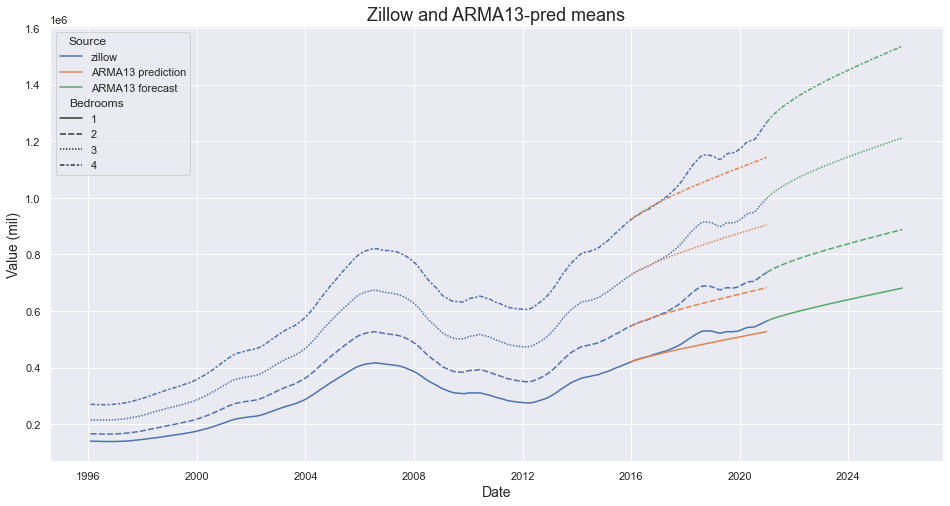

In [28]:
# plot the means using seaborn
sns.set_theme(style="darkgrid")
sea_mean = sea_df[sea_df['measure_type']=='mean'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow and ARMA13-pred means",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)

Text(0, 0.5, 'Value (mil)')

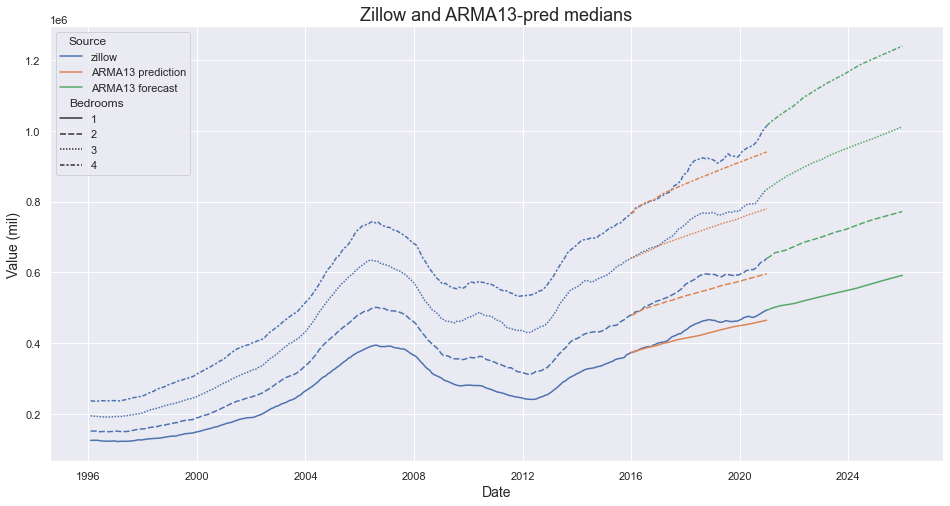

In [29]:
# plot the median using seaborn
sns.set_theme(style="darkgrid")
sea_median = sea_df[sea_df['measure_type']=='median'] #subset with only the median
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_median, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow and ARMA13-pred medians",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)

In [31]:
end=time.time()
total_time_min = int((end-start)/60)
print('Total run time: ' + str(total_time_min))

Total run time: 16
